In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mason_functions as mf

import sklearn.preprocessing
from sklearn.feature_selection import SelectKBest, f_regression, RFE
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

Do your work for this exercise in a jupyter notebook named feature_engineering within the regression-exercises repo. Add, commit, and push your work.

## Exercise I
Load the tips dataset.

a. Create a column named tip_percentage. This should be the tip amount divided by the total bill.

b. Create a column named price_per_person. This should be the total bill divided by the party size.

c. Before using any of the methods discussed in the lesson, which features do you think would be most important for predicting the tip amount? The tip percentage?

d. Use select k best and recursive feature elimination to select the top 2 features for predicting tip amount. What are they?

e. Use select k best and recursive feature elimination to select the top 2 features for predicting tip percentage. What are they?

f. Why do you think select k best and recursive feature elimination might give different answers for the top features? Does this change as you change the number of features your are selecting?

In [2]:
#load
tips = sns.load_dataset('tips')

In [3]:
#at a glance
tips.head()

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4


In [4]:
tips.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244 entries, 0 to 243
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   total_bill  244 non-null    float64 
 1   tip         244 non-null    float64 
 2   sex         244 non-null    category
 3   smoker      244 non-null    category
 4   day         244 non-null    category
 5   time        244 non-null    category
 6   size        244 non-null    int64   
dtypes: category(4), float64(2), int64(1)
memory usage: 7.4 KB


In [5]:
### A. Create a column named tip_percentage. This should be the tip amount divided by the total bill.
### B. Create a column named price_per_person. This should be the total bill divided by the party size.
tips['tip_percentage'] = tips['tip'] / tips['total_bill']
tips['price_per_person'] = tips['total_bill'] / tips['size']

In [6]:
#checking
tips.head()

,total_bill,tip,sex,smoker,day,time,size,tip_percentage,price_per_person
0,16.99,1.01,Female,No,Sun,Dinner,2,0.059447,8.495000
1,10.34,1.66,Male,No,Sun,Dinner,3,0.160542,3.446667
2,21.01,3.50,Male,No,Sun,Dinner,3,0.166587,7.003333
3,23.68,3.31,Male,No,Sun,Dinner,2,0.139780,11.840000
4,24.59,3.61,Female,No,Sun,Dinner,4,0.146808,6.147500


In [7]:
#disambiguity
tips.columns = tips.columns.str.replace('size', 'party_size')

In [8]:
#determine working categoric and numerical columns
quant_vars = ['total_bill', 'party_size', 'price_per_person']
cat_vars = ['sex', 'smoker', 'day', 'time']

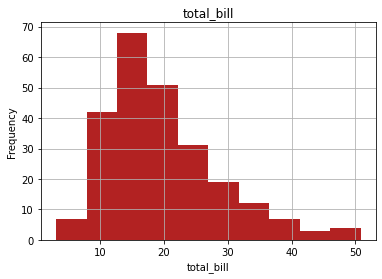

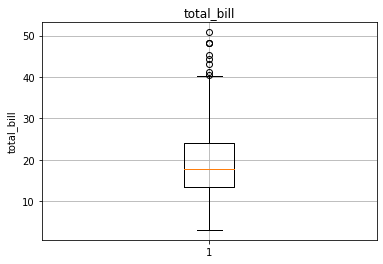

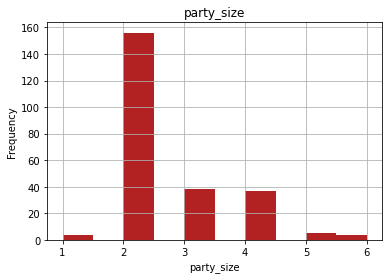

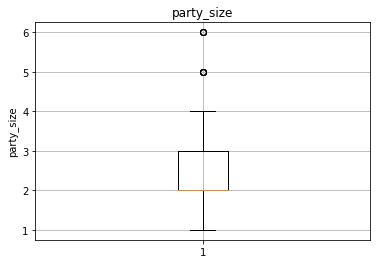

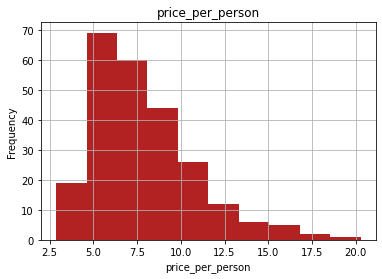

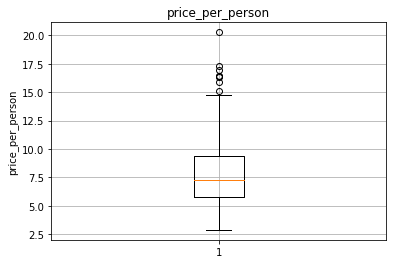

In [9]:
#distributions
for cat in quant_vars:
    tips[cat].hist(color = 'firebrick')
    plt.title(cat)
    plt.xlabel(cat)
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()
    plt.boxplot(tips[cat])
    plt.title(cat)
    plt.ylabel(cat)
    plt.grid(True)
    plt.show();

I will do a robust scale for my data (many outliers).

In [10]:
#one-hot encoding
dummy_df = pd.get_dummies(tips[cat_vars], dummy_na = False, drop_first = True)

In [11]:
#what it look like?
dummy_df.head()

,sex_Female,smoker_No,day_Fri,day_Sat,day_Sun,time_Dinner
0,1,1,0,0,1,1
1,0,1,0,0,1,1
2,0,1,0,0,1,1
3,0,1,0,0,1,1
4,1,1,0,0,1,1


In [12]:
#rename columns
dummy_df.columns = dummy_df.columns.str.lower().str.replace('day_', '').str.replace('time_', '').str.replace('_no', '').str.replace('sex_', '')

In [13]:
#concatenate
tips = pd.concat([tips.drop(columns = cat_vars), dummy_df], axis = 1)

In [14]:
#I like it
tips.head()

,total_bill,tip,party_size,tip_percentage,price_per_person,female,smoker,fri,sat,sun,dinner
0,16.99,1.01,2,0.059447,8.495000,1,1,0,0,1,1
1,10.34,1.66,3,0.160542,3.446667,0,1,0,0,1,1
2,21.01,3.50,3,0.166587,7.003333,0,1,0,0,1,1
3,23.68,3.31,2,0.139780,11.840000,0,1,0,0,1,1
4,24.59,3.61,4,0.146808,6.147500,1,1,0,0,1,1


In [15]:
#split it
train, validate, test = mf.split_data(tips)

In [16]:
#check it
train.shape, validate.shape, test.shape

((136, 11), (59, 11), (49, 11))

In [17]:
#create the object
scaler = sklearn.preprocessing.RobustScaler()

#fit the object
scaler.fit(train[quant_vars])

#use the object
train_scaled = scaler.transform(train[quant_vars])
validate_scaled = scaler.transform(validate[quant_vars])
test_scaled = scaler.transform(test[quant_vars])

#adding scaled columns
train[['total_bill_scaled', 'party_size_scaled', 'price_per_person_scaled']] = train_scaled
validate[['total_bill_scaled', 'party_size_scaled', 'price_per_person_scaled']] = validate_scaled
test[['total_bill_scaled', 'party_size_scaled', 'price_per_person_scaled']] = test_scaled

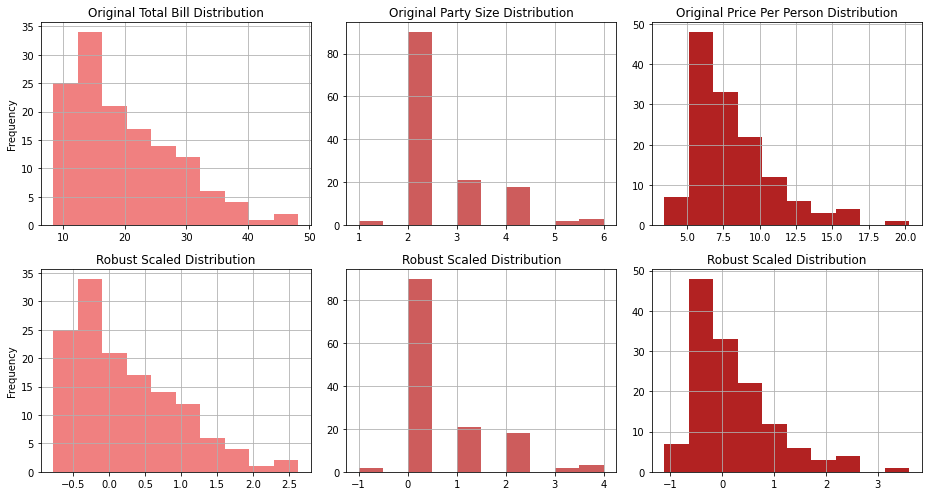

In [18]:
#visualize scaled vs unscaled (I just want to verify i've done it right)

#create figure
plt.figure(figsize = (13, 7))

#subplot 1
plt.subplot(231)
train.total_bill.hist(color = 'lightcoral')
plt.title('Original Total Bill Distribution')
plt.ylabel('Frequency')

#subplot 2
plt.subplot(234)
train.total_bill_scaled.hist(color = 'lightcoral')
plt.title('Robust Scaled Distribution')
plt.ylabel('Frequency')

#subplot 3
plt.subplot(232)
train['party_size'].hist(color = 'indianred')
plt.title('Original Party Size Distribution')


#subplot 4
plt.subplot(235)
train.party_size_scaled.hist(color = 'indianred')
plt.title('Robust Scaled Distribution')

#subplot 5
plt.subplot(233)
train.price_per_person.hist(color = 'firebrick')
plt.title('Original Price Per Person Distribution')

#subplot 6
plt.subplot(236)
train.price_per_person_scaled.hist(color = 'firebrick')
plt.title('Robust Scaled Distribution')

plt.tight_layout();

In [19]:
train.head()

,total_bill,tip,party_size,tip_percentage,price_per_person,female,smoker,fri,sat,sun,dinner,total_bill_scaled,party_size_scaled,price_per_person_scaled
97,12.03,1.50,2,0.124688,6.015000,0,0,1,0,0,1,-0.467066,0.0,-0.399181
20,17.92,4.08,2,0.227679,8.960000,0,1,0,1,0,1,0.036784,0.0,0.427970
40,16.04,2.24,3,0.139651,5.346667,0,1,0,1,0,1,-0.124038,1.0,-0.586893
38,18.69,2.31,3,0.123596,6.230000,0,1,0,1,0,1,0.102652,1.0,-0.338795
42,13.94,3.06,2,0.219512,6.970000,0,1,0,0,1,1,-0.303678,0.0,-0.130954


In [20]:
#get the X and y ready
not_scaled = ['total_bill', 'tip', 'party_size', 'tip_percentage', 'price_per_person']

In [21]:
#format modeling data
X_train = train.drop(columns = not_scaled)
y_train = train.tip

X_validate = validate.drop(columns = not_scaled)
y_validate = validate.tip

X_test = test.drop(columns = not_scaled)
y_test = test.tip

In [22]:
### C. Before using any of the methods discussed in the lesson, which features do you think would be most important for predicting the tip amount? The tip percentage?
#I think the most important feature will be party size
### D. Use select k best and recursive feature elimination to select the top 2 features for predicting tip amount. What are they?

#parameters: f_regression stats test, give me 2 features
best_feat = SelectKBest(f_regression, k = 2)

#find the top two X's correlated with y 
best_feat.fit(X_train, y_train)

#boolean mask of whether or not X was selected
feat_mask = best_feat.get_support()

#get the best features
best_features = X_train.iloc[:,feat_mask].columns.to_list()

In [23]:
#looks like I guessed right
best_features

['total_bill_scaled', 'party_size_scaled']

In [24]:
#crank it
lm = LinearRegression()

#pop it
rfe = RFE(lm, 2)

#bop it
rfe.fit(X_train, y_train)  

#twist it
feat_mask = rfe.support_

#pull it 
best_rfe = X_train.iloc[:,feat_mask].columns.tolist()

In [25]:
#bop it
best_rfe

['total_bill_scaled', 'price_per_person_scaled']

In [26]:
### E. Use select k best and recursive feature elimination to select the top 2 features for predicting tip percentage. What are they?
best_feat.fit(X_train, train['tip_percentage'])
feat_mask = best_feat.get_support()
best_features = X_train.iloc[:,feat_mask].columns.to_list()
best_features

['total_bill_scaled', 'price_per_person_scaled']

In [27]:
#crank it
lm = LinearRegression()

#pop it
rfe = RFE(lm, 2)

#bop it
rfe.fit(X_train, train['tip_percentage'])  

#twist it
feat_mask = rfe.support_

#pull it 
best_rfe = X_train.iloc[:,feat_mask].columns.tolist()

best_rfe

['fri', 'price_per_person_scaled']

F ### F. Why do you think select k best and recursive feature elimination might give different answers for the top features? Does this change as you change the number of features your are selecting?
They give different answers because they use different algorithms (one uses models and another runs stats tests. And yes, changing the number of best features does lead to different answers.

## Exercise II
Write a function named select_kbest that takes in the predictors (X), the target (y), and the number of features to select (k) and returns the names of the top k selected features based on the SelectKBest class. Test your function with the tips dataset. You should see the same results as when you did the process manually.

In [28]:
#X = predictors
#y = target
#k = number of features
def select_kbest(X, y, k):
    from sklearn.feature_selection import SelectKBest, f_regression, RFE
    best_feat = SelectKBest(f_regression, k = k)
    best_feat.fit(X_train, y_train)
    feat_mask = best_feat.get_support()
    best_features = X_train.iloc[:,feat_mask].columns.to_list()
    return best_features

select_kbest(X_train, y_train, 2)

['total_bill_scaled', 'party_size_scaled']

## Exercise III
Write a function named rfe that takes in the predictors, the target, and the number of features to select. It should return the top k features based on the RFE class. Test your function with the tips dataset. You should see the same results as when you did the process manually.

In [29]:
def rfe(X, y, k):
    from sklearn.feature_selection import SelectKBest, f_regression, RFE
    from sklearn.linear_model import LinearRegression
    #crank it
    lm = LinearRegression()

    #pop it
    rfe = RFE(lm, k)
    
    #bop it
    rfe.fit(X_train, y_train)  
    
    #twist it
    feat_mask = rfe.support_
    
    #pull it 
    best_rfe = X_train.iloc[:,feat_mask].columns.tolist()
    
    return best_rfe

rfe(X_train, y_train, 2)

['total_bill_scaled', 'price_per_person_scaled']

## Exercise IV
Load the swiss dataset and use all the other features to predict Fertility. Find the top 3 features using both select k best and recursive feature elimination (use the functions you just built to help you out).

In [30]:
from pydataset import data

In [31]:
swiss = data('swiss')

In [32]:
data('swiss', show_doc = True)

swiss

PyDataset Documentation (adopted from R Documentation. The displayed examples are in R)

## Swiss Fertility and Socioeconomic Indicators (1888) Data

### Description

Standardized fertility measure and socio-economic indicators for each of 47
French-speaking provinces of Switzerland at about 1888.

### Usage

    data(swiss)

### Format

A data frame with 47 observations on 6 variables, each of which is in percent,
i.e., in [0,100].

[,1] Fertility Ig, "common standardized fertility measure" [,2] Agriculture
[,3] Examination nation [,4] Education [,5] Catholic [,6] Infant.Mortality
live births who live less than 1 year.

All variables but 'Fert' give proportions of the population.

### Source

Project "16P5", pages 549-551 in

Mosteller, F. and Tukey, J. W. (1977) “Data Analysis and Regression: A Second
Course in Statistics”. Addison-Wesley, Reading Mass.

indicating their source as "Data used by permission of Franice van de Walle.
Office of Population Research, Princeton Univer

In [33]:
swiss.head()

,Fertility,Agriculture,Examination,Education,Catholic,Infant.Mortality
Courtelary,80.2,17.0,15,12,9.96,22.2
Delemont,83.1,45.1,6,9,84.84,22.2
Franches-Mnt,92.5,39.7,5,5,93.40,20.2
Moutier,85.8,36.5,12,7,33.77,20.3
Neuveville,76.9,43.5,17,15,5.16,20.6


In [34]:
#split the data
train, validate, test = mf.split_data(swiss)

In [35]:
#set up numeric columns as a list
quant_vars = ['Agriculture', 'Examination', 'Education', 'Catholic', 'Infant.Mortality']

In [36]:

#create the object
scaler = sklearn.preprocessing.RobustScaler()

#fit the object
scaler.fit(train[quant_vars])

#use the object
train_scaled = scaler.transform(train[quant_vars])
validate_scaled = scaler.transform(validate[quant_vars])
test_scaled = scaler.transform(test[quant_vars])

#add scaled columns
train[['Agriculture_scaled', 'Examination_scaled', 'Education_scaled', 'Catholic_scaled', 'Infant.Mortality_scaled']] = train_scaled
validate[['Agriculture_scaled', 'Examination_scaled', 'Education_scaled', 'Catholic_scaled', 'Infant.Mortality_scaled']] = validate_scaled
test[['Agriculture_scaled', 'Examination_scaled', 'Education_scaled', 'Catholic_scaled', 'Infant.Mortality_scaled']] = test_scaled

In [37]:
#represent scaled columns with a variable
scaled = ['Agriculture_scaled', 'Examination_scaled', 'Education_scaled', 'Catholic_scaled', 'Infant.Mortality_scaled']

In [38]:
#set up modeling data
X_train = train[scaled]
y_train = train.Fertility

X_validate = validate[scaled]
y_validate = validate.Fertility

X_test = test[scaled]
y_test = test.Fertility

In [39]:
#gimme
select_kbest(X_train, y_train, 3)

['Education_scaled', 'Catholic_scaled', 'Infant.Mortality_scaled']

In [40]:
#pull it
rfe(X_train, y_train, 3)

['Agriculture_scaled', 'Education_scaled', 'Catholic_scaled']